# Please execute the following python file first!

```python3 ./libml/extract_accuracies.py```

In [1]:
from glob import glob
import numpy as np
import json
import pandas as pd

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
dataset = 'cifar10'

# Datasets vs accuracy

In [3]:
def summarize_final_results(data=dataset, split='test', n_last=20):
    '''
    Calculate the mean and standard deviation of results of the last 'n_last' epochs.
    '''

    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','l2_0.0005_','l2_0.001_','l2_0.0025_']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            try:
                exp_name = '{}_{}_{}'.format(data, model, str(sample))
                path_list = sorted(
                            glob(
                                '../experiments/acc_all/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                            ))
                tmp = []
                for path in path_list:
                    f = json.load(open(path, "r"))
                    tmp.append(pd.DataFrame(f, index=split_list))

                try: 
                    tmp = pd.concat(tmp, sort=False)
                    tmp_test = tmp.loc['test'].iloc[:,-n_last:]
                except:
                    print('Based on the only one seed', model, sample, len(path_list))
                    tmp_test = tmp.loc['test'].iloc[-n_last:]

                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                            'mean': tmp_test.mean().mean(),
                            'std': tmp_test.std().mean()}
                df = df.append(tmp_dict, ignore_index=True)
            except:
                print(model, data, sample)
                pass

    return df

In [4]:
def summarize_gradients(data=dataset):
    '''
    Summarize the gradients for each models
    '''
    
    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['l2_0.0005_','l2_0.001_','l2_0.0025_']
    df = pd.DataFrame(columns=['data','model','sample', 'gradients'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                glob(
                    '../experiments/acc_all/{}*/{}.*@{}-1/*/gradients.txt'.format(model, data, sample)
                )
            )
            tmp = []
            for path in path_list:
                f = json.load(open(path_list[0], "r"))
                tmp = tmp + f['gradients']
            tmp_dict = {'data': data,
                        'model': model,
                        'sample': sample,
                        'gradients': tmp
                       }
            df = df.append(tmp_dict, ignore_index=True)
    return df

In [6]:
summarize_gradients(data=dataset)

,data,model,sample,gradients
0,cifar10,l2_0.0005_,100,"[1.6287976503372192, 1.1668154001235962, 2.499..."
1,cifar10,l2_0.0005_,500,"[0.7339191436767578, 0.5213144421577454, 1.186..."
2,cifar10,l2_0.0005_,1000,"[1.2139203548431396, 0.41163793206214905, 0.71..."
3,cifar10,l2_0.0005_,2500,"[0.1554722934961319, 0.5377103090286255, 0.186..."
4,cifar10,l2_0.0005_,5000,"[0.4548030197620392, 0.3347723186016083, 0.150..."
5,cifar10,l2_0.0005_,25000,"[0.16506309807300568, 0.10242167115211487, 0.4..."
6,cifar10,l2_0.0005_,50000,"[0.053903501480817795, 0.29585254192352295, 0...."
7,cifar10,l2_0.001_,100,"[1.8096688985824585, 0.5735642313957214, 0.528..."
8,cifar10,l2_0.001_,500,"[0.8655413389205933, 0.702879011631012, 0.9400..."
9,cifar10,l2_0.001_,1000,"[2.0921571254730225, 0.08533164113759995, 0.36..."


In [33]:
def show_summary_plot(data=dataset):
    df_data = summarize_final_results(data=data, n_last=20)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    models=['erm','mixup','l2_0.0005_','l2_0.001_','l2_0.0025_']
    names=['ERM','Mixup','l2_0.0005','l2_0.001','l2_0.0025']
    colors=['dodgerblue','yellowgreen','red','purple','blue']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Test accuracy (in %)', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    
    for i in range(len(colors)):
        ymean = df_data['mean'][df_data['model']==models[i]]
        yerr = df_data['std'][df_data['model']==models[i]]
        plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
        plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    #plt.ylim(86,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()
    

In [34]:
def show_lipschitz_plot(data=dataset):
    df_data = summarize_gradients(data=data)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    #models=['erm','mixup','l2_0.0005_','l2_0.0025_','l2_0.001_']
    #names=['ERM','Mixup','l2_0.0005','l2_0.0025','l2_0.001']
    #colors=['dodgerblue','yellowgreen','red','purple','blue']
    models=['l2_0.0005_','l2_0.001_','l2_0.0025_']
    names=['l2_0.0005','l2_0.001','l2_0.0025']
    colors=['dodgerblue','yellowgreen','red']
    
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Lipschitz', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    
    for i in range(len(colors)):
        ymean = df_data['mean'][df_data['model']==models[i]]
        yerr = df_data['std'][df_data['model']==models[i]]
        plt.plot(np.log(x_list), ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
        plt.fill_between(np.log(x_list), ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    #plt.ylim(86,88)
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()
    

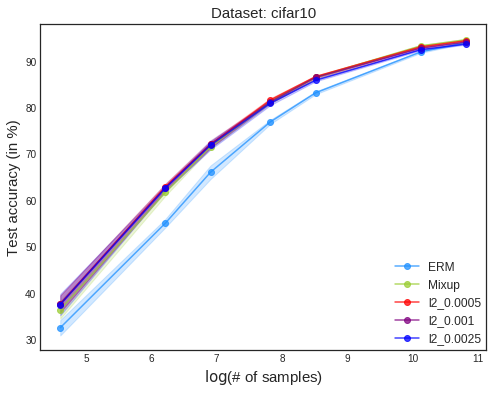

In [35]:
show_summary_plot(data=dataset)

In [36]:
def summary_table(data=dataset):
    df_data = summarize_final_results(data, n_last=20)
    ncol = 2 + len(df_data['model'].drop_duplicates())
    nrow = 1 + len(df_data['sample'].drop_duplicates())
    model_names = [data.replace('_', '-') for data in df_data['model'].drop_duplicates()]
    line = str(r'\begin{tabular}{|' + 'c|'*ncol + '}\n'
               + r'\hline' + '\n'
              )
    line = line + r'Dataset & Sample size'
    for model_name in model_names:
        line = line + ' & ' + model_name
    line = line + r'\tabularnewline' + '\n'
    line = line + str(r'\hline' + '\n'
                      + r'\hline' + '\n'
                      + r'\multirow{5}{*}{%s}' % df_data['data'][0] + '\n'
                     ) 
    for sample in sorted(df_data['sample'].drop_duplicates()):
        line = line + '& %d ' % sample
        for model in df_data['model'].drop_duplicates():
            ind = (df_data['sample'] == sample) & (df_data['model'] == model)
            line = line + r'& %.2f $\pm$ %.2f ' % (df_data['mean'][ind], df_data['std'][ind])
        line = line + r'\tabularnewline' + '\n'
        line = line + r'\cline{2-%d}' % ncol + '\n'
    line = line[:-12]
    line = line + r'\hline' + '\n' + r'\end{tabular}'
    return line

In [37]:
print(summary_table(data=dataset))

\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
Dataset & Sample size & erm & mixup & l2-0.0005- & l2-0.001- & l2-0.0025-\tabularnewline
\hline
\hline
\multirow{5}{*}{cifar10}
& 100 & 32.60 $\pm$ 1.67 & 36.49 $\pm$ 1.92 & 37.70 $\pm$ 1.86 & 37.81 $\pm$ 1.78 & 37.60 $\pm$ 2.31 \tabularnewline
\cline{2-7}
& 500 & 55.15 $\pm$ 0.92 & 61.79 $\pm$ 0.73 & 63.04 $\pm$ 0.58 & 62.82 $\pm$ 0.87 & 62.69 $\pm$ 0.51 \tabularnewline
\cline{2-7}
& 1000 & 66.16 $\pm$ 1.47 & 71.68 $\pm$ 0.31 & 72.15 $\pm$ 0.68 & 72.23 $\pm$ 0.83 & 71.97 $\pm$ 0.91 \tabularnewline
\cline{2-7}
& 2500 & 77.02 $\pm$ 0.45 & 81.40 $\pm$ 0.45 & 81.74 $\pm$ 0.38 & 81.36 $\pm$ 0.33 & 81.05 $\pm$ 0.43 \tabularnewline
\cline{2-7}
& 5000 & 83.29 $\pm$ 0.30 & 86.63 $\pm$ 0.25 & 86.79 $\pm$ 0.23 & 86.60 $\pm$ 0.23 & 85.99 $\pm$ 0.23 \tabularnewline
\cline{2-7}
& 25000 & 92.11 $\pm$ 0.20 & 93.41 $\pm$ 0.22 & 93.20 $\pm$ 0.13 & 92.91 $\pm$ 0.20 & 92.58 $\pm$ 0.14 \tabularnewline
\cline{2-7}
& 50000 & 94.13 $\pm$ 0.15 & 94.74 $\pm$ 0.15 & 94.53

In [12]:
def show_lipschitz_plot(data=dataset):
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel(r'$||\nabla_x h||_{\infty}$', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    df = summarize_gradients(dataset)
    x = df['sample'].drop_duplicates().values
    x_array = np.log(np.array(x, dtype='float32'))
    colors=['dodgerblue','yellowgreen','red','purple','blue']
    for i, model in enumerate(df['model'].drop_duplicates()):
        avg = np.array([])
        sd = np.array([])
        for sample in df['sample'].drop_duplicates():
            ind = (df['model'] == model) & (df['sample'] == sample)
            gradients = df['gradients'][ind].values[0]
            avg= np.append(avg, np.mean(gradients))
            sd= np.append(sd, np.std(gradients))
        plt.plot(x_array, avg, marker='o', label=model, color=colors[i], alpha=0.75)
        plt.fill_between(x_array, avg-sd, avg+sd, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    plt.legend()
    plt.show()

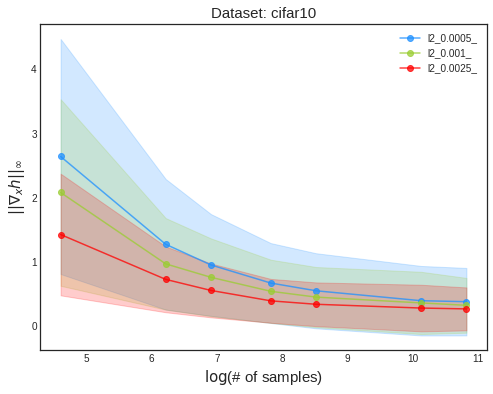

In [13]:
show_lipschitz_plot(dataset)

# Epochs vs Test accuracy

In [14]:
def summarize_learning_history(data='cifar10'):
    
    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models=['erm','mixup','l2_0.0005_','l2_0.0025_','l2_0.001_']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                        glob(
                            '../experiments/acc_all/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                        ))
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                tmp.append(pd.DataFrame(f, index=split_list))
            
            tmp = pd.concat(tmp, sort=False)
            test_acc = tmp.loc['test'].values
            
            try:
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': np.mean(test_acc, axis=0),
                           'std': np.std(test_acc, axis=0)}
            except:
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': list(test_acc),
                           'std': np.zeros(len(list(test_acc)))}
                
            
            df = df.append(tmp_dict, ignore_index=True)

    return df


In [15]:
def plot_test_acc(data=dataset, sample=50000):
    df = summarize_learning_history(dataset)
    x_list = np.arange(100)
    
    models=['erm','mixup','l2_0.0005_','l2_0.001_','l2_0.0025_']
    names=['ERM','Mixup','l2_0.0005','l2_0.001','l2_0.0025']
    colors=['dodgerblue','yellowgreen','red','purple','blue']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Test accuracy (in %)', fontsize=15)
    plt.title('Dataset-sample size:{}-{}'.format(data,sample), fontsize=15)
    
    for i in range(len(colors)):
        ind = (df['model']==models[i]) & (df['sample']==sample)
        ymean = df['mean'][ind].values[0]
        yerr = df['std'][ind].values[0]
        plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.5) 
        plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
        
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    #plt.ylim(4,5.5)
    plt.show()

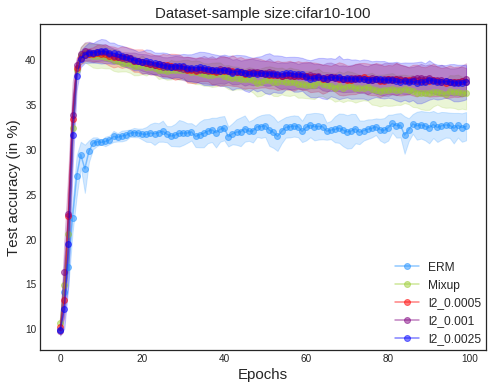

In [24]:
plot_test_acc(data=dataset,sample=100)

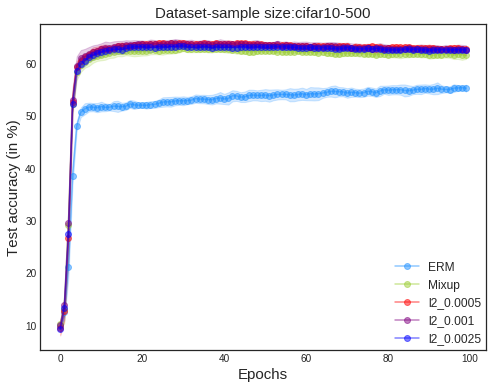

In [25]:
plot_test_acc(data=dataset,sample=500)

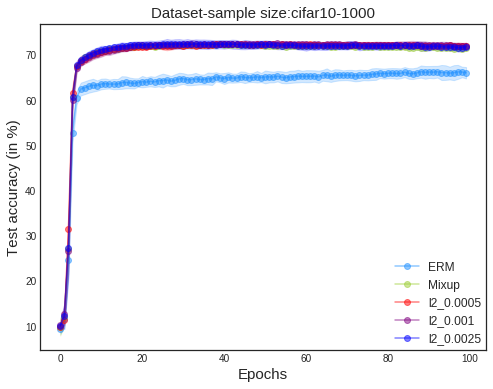

In [19]:
plot_test_acc(data=dataset,sample=1000)

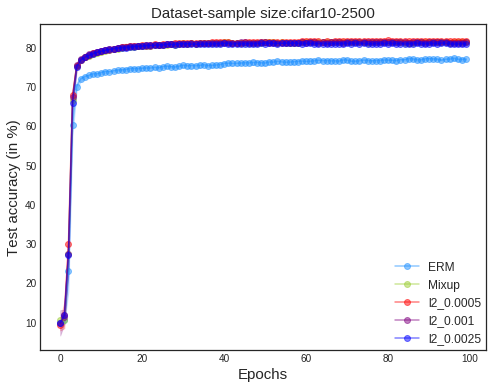

In [20]:
plot_test_acc(data=dataset,sample=2500)

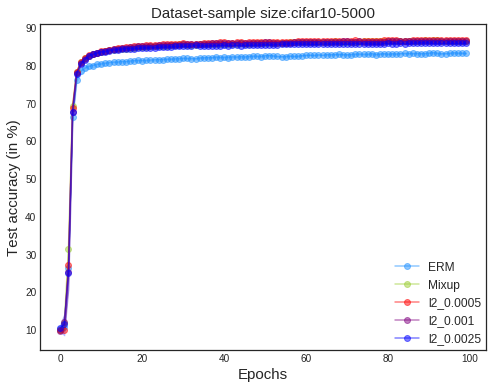

In [21]:
plot_test_acc(data=dataset,sample=5000)

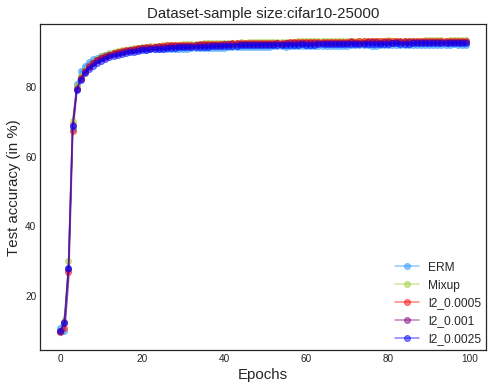

In [22]:
plot_test_acc(data=dataset,sample=25000)

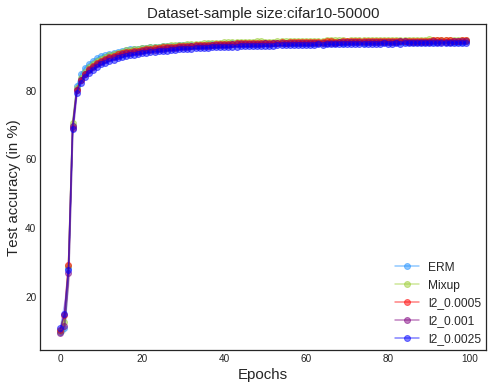

In [23]:
plot_test_acc(data=dataset,sample=50000)